In [102]:
import numpy as np
from matplotlib.path import Path
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'../src/')

from utils import *
from pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *
from pipe_system.let_index import LetIndex
from copy import deepcopy

from abstract_pipe.let import BoundaryLet
from curve import Cap

In [103]:
with open('dev_Pipes.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

In [104]:
bdr_pipe = BoundaryPipe([BoundaryLet(-10,0,0,2,1),BoundaryLet(36,0,np.pi,2,-1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
ps = PipeSystem(real_pipes,bdr_pipe)

In [105]:
caps_to_keep = []

for v in ps.vertices:
    if v.atBdr:
        l = v.l1 if isinstance(v.l1, BoundaryLet) else v.l2
        caps_to_keep.append((l.pipeIndex,l.letIndex))

In [122]:
curves = []
for pipe_index, pipe in enumerate(ps.pipes):
    
    shift = pipe.shift
    pipe = pipe.prototye
    c_index2l_index = {c:l for l,c in enumerate(pipe.let_index2curve_index)}
    
    for curve_index, curve in enumerate(pipe.curves):
        
        if isinstance(curve, Cap):
            let_index = c_index2l_index[curve_index]
            if (pipe_index, let_index) not in caps_to_keep:
                continue
        
        c = deepcopy(curve)
        for p in c.panels:
            p.x += shift[0]
            p.y += shift[1]
        
        c.start_pt += shift
        c.end_pt += shift
        c.mid_pt += shift
        
        if isinstance(c, Cap):
            c.matching_pt += shift
        curves.append(c)

In [172]:
import networkx as nx

In [130]:
def pt2tuple(pt):
    assert pt.shape == (2,)
    return (pt[0],pt[1])

In [ ]:
class Edge:
    def __init__(self, curve):
        self.start_pt = curve.start_pt
        self.end_pt = curve.end_pt
        self.curve = curve
    

In [217]:
G = nx.Graph()

for c in curves:
    G.add_edge(pt2tuple(c.start_pt),pt2tuple(c.end_pt), curve=c)

pts = np.array(list(G.nodes))
pts_cplx = pts[:,0] + 1j*pts[:,1]
distance = np.abs(pts_cplx[:,None] - pts_cplx[None,:])
need_to_merge = (distance < 1e-10) & (distance > 0)

while np.any(need_to_merge):
    i,j = np.array(np.where(need_to_merge)).T[0]
    
    node1 = list(G.nodes)[i]
    node2 = list(G.nodes)[j]

    nx.contracted_nodes(G,node1,node2, self_loops=False, copy=False)
    
    pts = np.array(list(G.nodes))
    pts_cplx = pts[:,0] + 1j*pts[:,1]
    distance = np.abs(pts_cplx[:,None] - pts_cplx[None,:])
    need_to_merge = (distance < 1e-9) & (distance > 0)
    
assert len(G.nodes) == len(set(G.edges))

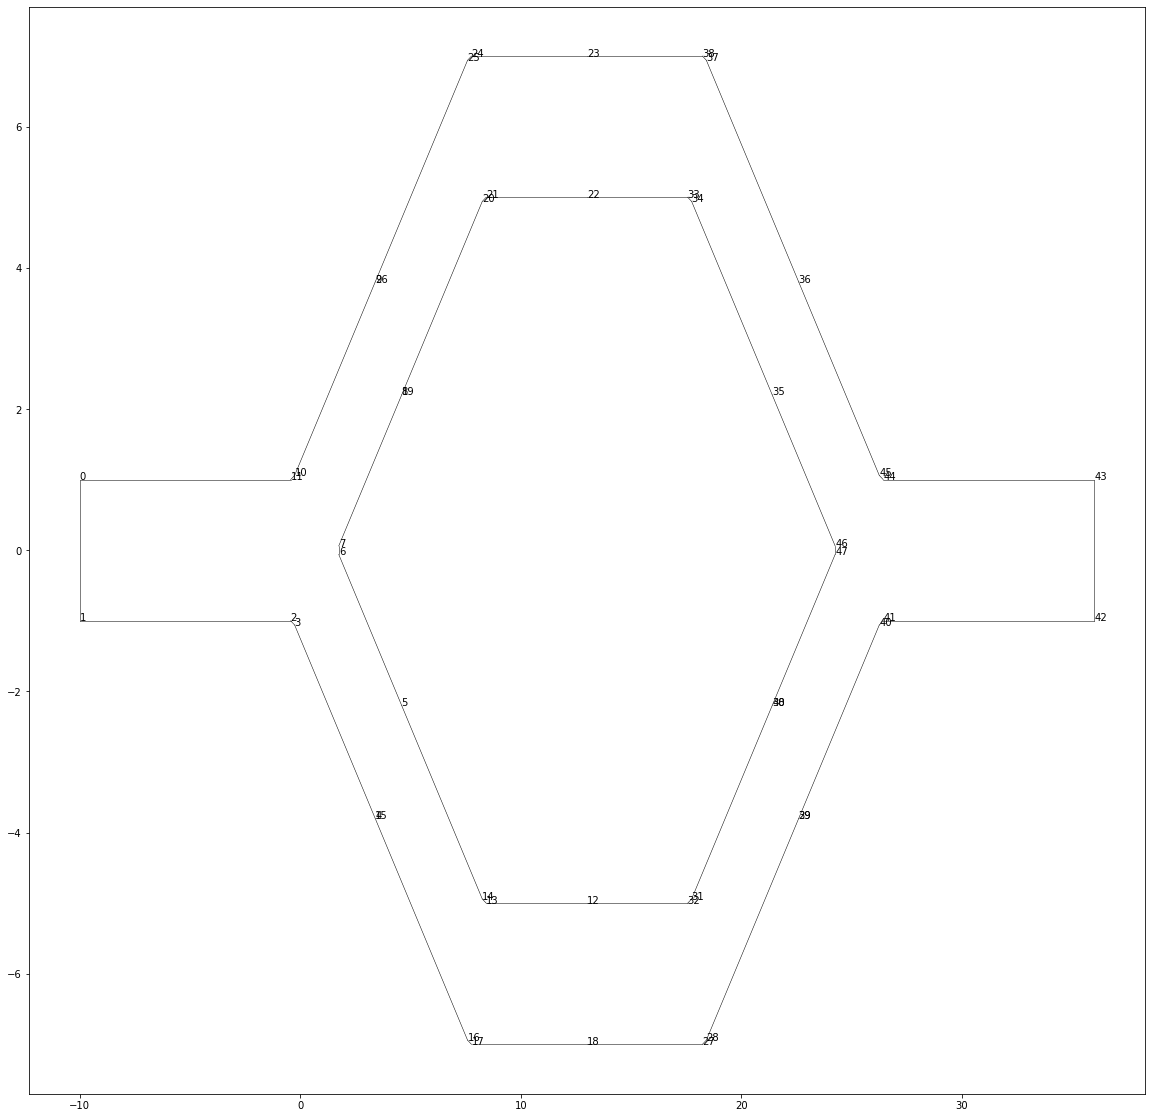

In [147]:
plt.figure(figsize=(20,20))

for i,node in enumerate(G.nodes):
    x,y = node
    plt.text(x,y,i)
    
for edge in G.edges:
    x1,y1 = edge[0]
    x2,y2 = edge[1]
    plt.plot([x1,x2],[y1,y2],c='k',lw=0.5)

In [227]:
boundaries = []
for c in nx.cycle_basis(G):
    curves = []
    for node1,node2 in zip(c, c[1:] + c[:1]):
        curves.append(G.edges[node1,node2]['curve'])
    boundaries.append(curves)
    
boundaries = sorted(boundaries, key=lambda boundary: np.min(np.concatenate([c.t.imag for c in boundary])))

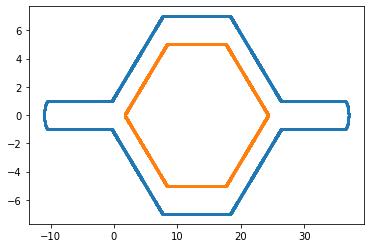

In [231]:
for b in boundaries:
    p = Pipe()
    p.curves = b
    t = p.t
    x = t.real
    y = t.imag
    plt.scatter(x,y,s=1)

----

In [123]:
pipe = Pipe()
pipe.curves = curves

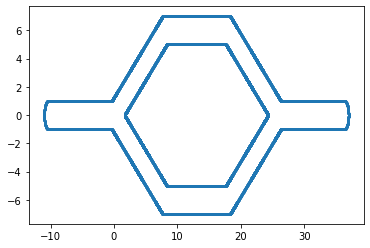

In [121]:
t = pipe.t
x = t.real
y = t.imag
plt.scatter(x,y,s=1)